A simplified version of the game Battleship is used to train an agent using Reinforcement Learning. 

The board will consist of a single row with n columns, or squares. Only one ship is allowed and has a size of m<n squares. 

The expectation is for the agent to learn to
a) fire at intervals of m squares (because a ship has a size of m squares and one would sample the space quicker this way), and
b) fire at squares adjacent to the previous hit. 

We believe this policy minimizes the number of shots required to sink the ship. 

Once this is achieved, we will move on to more, larger ships, and a bigger board. 

Let's first develop the game engine:

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def genShipCoords(shipSize,minCoord,maxCoord):
    """Generate ship coordinates randomly.

    Arguments:
    shipSize -- 
    minCoord -- 
    maxCoord -- 
    
    Example: Assuming one wants the coordinates of a ship of length 3 on a board of size 10x1, one would
    call the function: 
    ship = genShipCoords(3, 10, 1)
    # ship returns a list with the coorindates (e.g. [3,4,5])
    """
    
    coordinates = [0]*shipSize
    coordinates[0] = random.randint(minCoord,maxCoord)
    for i in range(1,shipSize):
        coordinates[i] = coordinates[i-1] + 1 if coordinates[i-1] < maxCoord else coordinates[i-1]-1
    return coordinates

In [9]:
class SimpleBattleship(object):
    
    # Only a one-row board is implemented for now
    def __init__(self, shipCoords, boardRows, boardCols):
        self.shipCoords = shipCoords
        self.boardSize = boardCols
        self.board = np.zeros(boardCols) 
        
    def fireShot(self, shotCoordinate):
        if shotCoordinate>self.boardSize or shotCoordinate<0:
            return 2
        elif shotCoordinate in self.shipCoords:
            # Hit
            self.updateState(shotCoordinate)
            return 1
        else:
            # Miss
            return 0
    def getState(self):
        return self.board
    
    def updateState(self,coord):
        self.board[coord] = 1
    

def randomAttacker():
    shotsTaken = []
    numShotsTaken = 0
    numHits = 0
    numMisses = 0
    while True:
        randomShot = random.randint(BOARD_SIZE[0], BOARD_SIZE[1])
        #print(randomShot)

        if randomShot in shotsTaken:
            dummy=1
            #print("INVALID")
        else:
            numShotsTaken += 1
            if attacker.fireShot(randomShot)==1:
                #print("HIT")
                numHits += 1
            else:
                #print("MISS")
                numMisses += 1

        shotsTaken.append(randomShot)

        if numHits == 2 or numMisses==25:
            break
    return 100*numShotsTaken/BOARD_SIZE[1]

    
#     print("Number of shots taken:{}".format(numShotsTaken))
#     print("Number of misses:{}".format(numMisses))
#     print("% of board covered to sink ship:{}".format(100*numShotsTaken/BOARD_SIZE[1]) )

In [11]:
# Play a game
BOARD_SIZE = (1,10)
SHIP_SIZE = 2

ship = genShipCoords(SHIP_SIZE, BOARD_SIZE[0], BOARD_SIZE[1])
print(ship)

[6, 7]


Let's test the getState method in the simpleBattleShip class. 

In [20]:
attacker = SimpleBattleship(ship, BOARD_SIZE[0], BOARD_SIZE[1])
attacker.fireShot(ship[0])
print(attacker.getState())

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


The avg percentCovered was:72.836


array([0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])

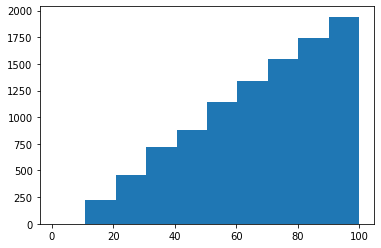

In [5]:
NUM_EPISODES = 10000
percentCovered = np.empty(NUM_EPISODES, dtype=int)

for i in range(NUM_EPISODES):
    percentCovered[i] = randomAttacker()
    
print("The avg percentCovered was:{}".format(percentCovered.mean()))
## fig = plt.hist(percentCovered,normed=True,range=(1,100)); failed last time
fig = plt.hist(percentCovered,range=(1,100));
attacker.getState()

Now that we have a decent, simple battleship engine, let's focus on the reinforcement learning. 

The following algorithm is based on an actual Q-table. 

initialize Q[numstates,numactions] arbitrarily
observe initial state s
repeat
    select and carry out an action a
    observe reward r and new state s'
    Q[s,a] = Q[s,a] + α(r + γmaxa' Q[s',a'] - Q[s,a])
    s = s'
until terminated

In [6]:
# #utility functions
# actionSetToStr = {-1:"LEFT",1:"RIGHT"}


# # ACTUAL TRAINING

# NUM_EPISODES = 10000
# BOARD_SIZE = (1,10)
# SHIP_SIZE = 2
# ship = genShipCoords(SHIP_SIZE, BOARD_SIZE[0], BOARD_SIZE[1])
# print("SHIP LOCATION:{}".format(ship))
# attacker = SimpleBattleship(ship, BOARD_SIZE[0], BOARD_SIZE[1])
# # let's assume we don't know the number of states
# Q  = {} #Q-table
# actionSet = (-1,1) #LEFT=-1, RIGHT= +1
# R = {1:1, 0:-1, 2:-100} #Reward function: +1 if HIT(1), -1 if MISS(0), -100 if INVALID(2)
# s = attacker.getState()
# crossHairCoord = 0 # agent starts w/ cross-hair at coordinate 0 
# for _ in range(2):
#     a = random.choice(actionSet)
#     print("random action is " + actionSetToStr[a])
    
#     crossHairCoord += a
#     print("crosshair moved to {}".format(crossHairCoord))

#     r = R[attacker.fireShot(randomShot)]
#     s1 = attacker.getState()
     
#     Q[s] = 1
#     print(r)
#     print(s1)


One algorithm that uses rollouts is:

initialize replay memory D
initialize action-value function Q with random weights
observe initial state s
repeat
    select an action a
        with probability ε select a random action
        otherwise select a = argmaxa’Q(s,a’)
    carry out action a
    observe reward r and new state s’
    store experience <s, a, r, s’> in replay memory D

    sample random transitions <ss, aa, rr, ss’> from replay memory D
    calculate target for each minibatch transition
        if ss’ is terminal state then tt = rr
        otherwise tt = rr + γmaxa’Q(ss’, aa’)
    train the Q network using (tt - Q(ss, aa))^2 as loss

    s = s'
until terminated